In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv("Mall_Customers.csv")

In [3]:
# Mostrar las primeras filas para conocer la estructura de los datos
print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
# Información general del dataset: tipos de datos y valores no nulos
print("\nInformación del dataset:")
data.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# Verificar si existen valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())


Valores nulos por columna:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [6]:
# Eliminar duplicados 
data = data.drop_duplicates()

In [8]:
# Conversión de variables categóricas a numéricas:
# Convertir 'Gender' a valores numéricos (Male: 0, Female: 1)
data['Genre'] = data['Genre'].map({'Male': 0, 'Female': 1})

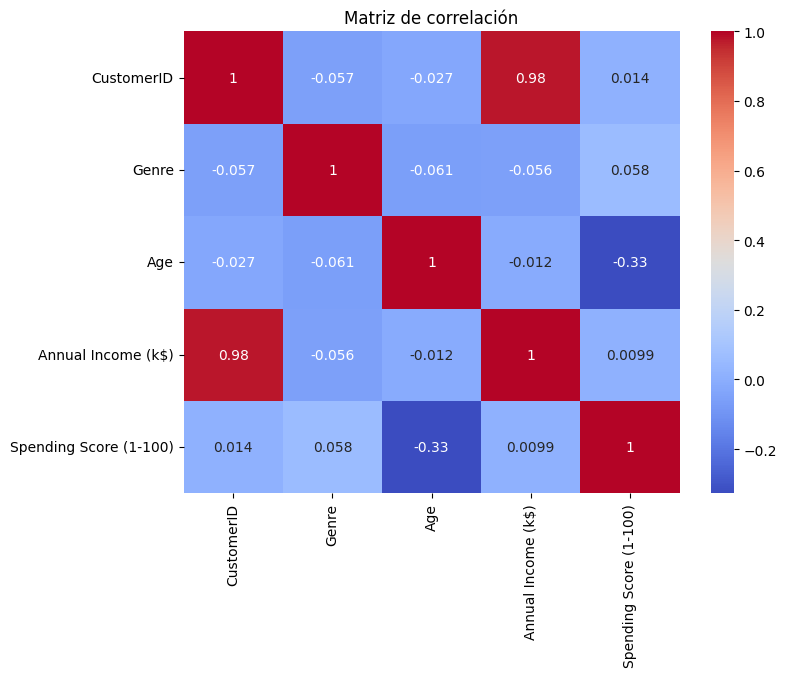

In [9]:
# Visualización de la correlación entre las variables para entender relaciones
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

In [11]:
# Escalado de las características numéricas (excepto CustomerID) para prepararlas para clustering
scaler = StandardScaler()
# Seleccionamos las columnas que vamos a escalar (omitiendo CustomerID)
features = data.drop('CustomerID', axis=1)
features_scaled = scaler.fit_transform(features)
# Convertimos a DataFrame para facilitar el análisis posterior
data_scaled = pd.DataFrame(features_scaled, columns=features.columns)

print("\nDatos escalados:")
print(data_scaled.head())



Datos escalados:
      Genre       Age  Annual Income (k$)  Spending Score (1-100)
0 -1.128152 -1.424569           -1.738999               -0.434801
1 -1.128152 -1.281035           -1.738999                1.195704
2  0.886405 -1.352802           -1.700830               -1.715913
3  0.886405 -1.137502           -1.700830                1.040418
4  0.886405 -0.563369           -1.662660               -0.395980


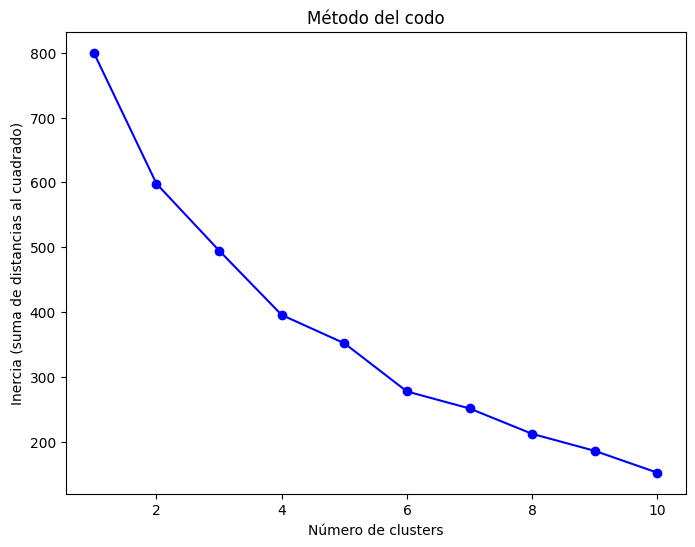

In [13]:
# Método del codo para determinar el número óptimo de clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (suma de distancias al cuadrado)")
plt.title("Método del codo")
plt.show()

Clusters: 2, Silhouette Score: 0.278
Clusters: 3, Silhouette Score: 0.258
Clusters: 4, Silhouette Score: 0.290
Clusters: 5, Silhouette Score: 0.272
Clusters: 6, Silhouette Score: 0.335
Clusters: 7, Silhouette Score: 0.346
Clusters: 8, Silhouette Score: 0.373
Clusters: 9, Silhouette Score: 0.388
Clusters: 10, Silhouette Score: 0.421


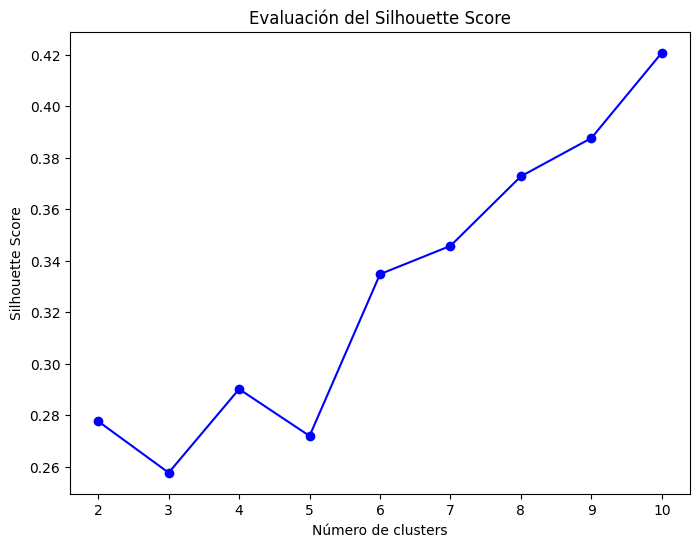

In [14]:
# Método del Silhouette Score para evaluar la calidad de los clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.3f}")

plt.figure(figsize=(8,6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.title("Evaluación del Silhouette Score")
plt.show()

In [15]:
# Suponiendo que ambos métodos sugieren que 5 clusters es un buen número
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

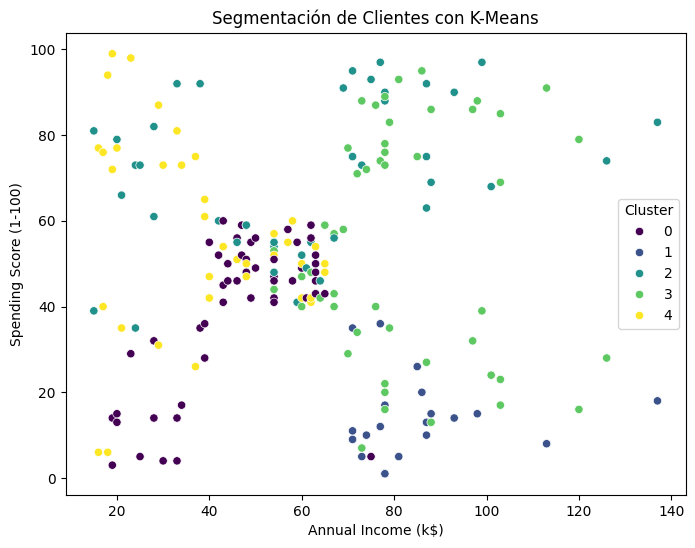

In [16]:
# Visualización de los clusters usando dos características relevantes: Ingreso Anual y Puntaje de Gasto
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=data, palette='viridis')
plt.title("Segmentación de Clientes con K-Means")
plt.show()

In [18]:
# Mostrar la distribución de clientes por cluster
print("Distribución de clientes por cluster:")
print(data['Cluster'].value_counts())

Distribución de clientes por cluster:
Cluster
0    51
3    49
2    42
4    38
1    20
Name: count, dtype: int64


In [19]:
# Función para eliminar outliers en una columna usando IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar eliminación de outliers a columnas numéricas relevantes
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
data_clean = data.copy()
for col in numerical_columns:
    data_clean = remove_outliers(data_clean, col)

print("Dimensiones después de eliminar outliers:", data_clean.shape)


Dimensiones después de eliminar outliers: (198, 6)


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionar las variables a usar (excluyendo CustomerID)
features = data_clean.drop('CustomerID', axis=1)
# Asegurarse de que 'Gender' esté en formato numérico
features['Genre'] = features['Genre'].map({'Male': 0, 'Female': 1})

# Escalar las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [24]:
from sklearn.impute import SimpleImputer

# Manejar valores NaN en features_scaled
imputer = SimpleImputer(strategy='mean')  # Puedes cambiar la estrategia si es necesario
features_scaled_imputed = imputer.fit_transform(features_scaled)

# Aplicar PCA para reducir a 2 componentes
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled_imputed)

# Visualizar la varianza explicada
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

Varianza explicada por cada componente: [0.47929441 0.2504863 ]


c:\Users\luisa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


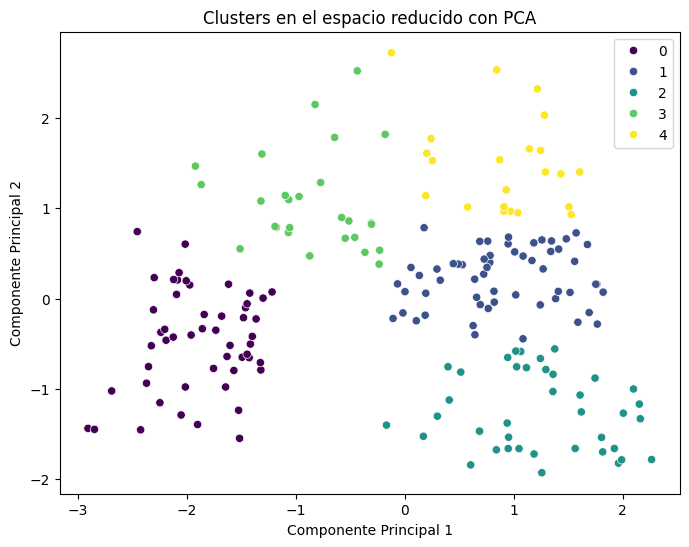

In [25]:
# Aplicar K-Means en el espacio reducido
from sklearn.cluster import KMeans
optimal_k = 5  # Este valor puede ajustarse según los métodos de validación
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)
clusters_pca = kmeans_pca.fit_predict(features_pca)

# Agregar el resultado de clustering al DataFrame original
data_clean['Cluster_PCA'] = clusters_pca

# Visualización de los clusters en el espacio de PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1],
                hue=clusters_pca, palette='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clusters en el espacio reducido con PCA")
plt.show()


In [26]:
# Mostrar la distribución de clientes por cluster
print("Distribución de clientes por cluster:")
print(data['Cluster'].value_counts())

Distribución de clientes por cluster:
Cluster
0    51
3    49
2    42
4    38
1    20
Name: count, dtype: int64
